In [44]:
# -*- coding: utf-8 -*-
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn import metrics
from sklearn.ensemble import  RandomForestClassifier
#changement de dossier
import os
os.chdir("/home/abdou/Documents/jupyter/OCS-SENTINEL/")

In [45]:
# Import OGR - 
from osgeo import ogr
# Open the dataset from the file
dataset = ogr.Open('bordeaux_label.shp') 
### What is the name of the 1 layer?
layer = dataset.GetLayerByIndex(0) 

In [46]:

# Import GDAL
from osgeo import gdal

# First we will open our raster image, to understand how we will want to rasterize our vector
raster_ds = gdal.Open('bordeaux1.tif', gdal.GA_ReadOnly)

# Fetch number of rows and columns
ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('training_data3classes.tif', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=classes']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


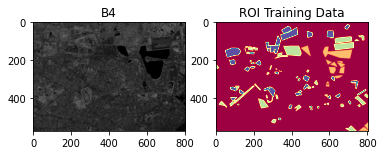

Class 0 contains 406094 pixels
Class 1 contains 11445 pixels
Class 2 contains 21130 pixels
Class 3 contains 20647 pixels


In [47]:
#Importer les images
img_ds = gdal.Open('bordeaux1.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('training_data3classes.tif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
 
# Affichez-les
plt.subplot(121)
plt.imshow(img[:, :,3 ], cmap='gray')
plt.title('B4')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()
# Importer NumPy pour certaines statistiques
import numpy as np

roi_ds = gdal.Open('training_data3classes.tif', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# Combien de pixels y a-t-il dans chaque classe?
classes = np.unique(roi)
# Afficher le nombre de pixels par classes
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

In [48]:
# #### Association de Y avec X
# Maintenant que nous avons l'image que nous voulons classer (nos entrées de fonctionnalités X),
#et le retour sur investissement avec les étiquettes de couverture terrestre (nos données étiquetées Y), nous devons les coupler
# dans les tableaux NumPy afin que nous puissions les transmettre aux modèles:


# Trouvez combien d'entrées non nulles nous avons : c'est-à-dire combien d'échantillons de données d'entraînement?
n_samples = (roi > 0).sum()
print('Nous avons {n} pixels'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# Nous aurons besoin d'une matrice "X" contenant nos caractéristiques, et d'un tableau "y" contenant nos étiquettes
# Ceux-ci auront n_samples lignes

X = img[roi > 0, :]  # inclure toutes les bandes
y = roi[roi > 0]

print('Dimensions du tableau en X: {sz}'.format(sz=X.shape))
print('Dimensions du tableauen  Y: {sz}'.format(sz=y.shape))

# Scinder les données en deux: apprentissage et test

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, shuffle=True,random_state=42,stratify=y)

#outil standardisation
from sklearn.preprocessing import StandardScaler
#centrage-réduction des variables
cr = StandardScaler(with_mean=True,with_std=True)
#calcul des paramètres + centrage réduction du train set
XTrainStd = cr.fit_transform(X_train)
#comparaison des moyennes, avant…
print(np.mean(X_train,axis=0))
#... et après CR (centrage-réduction)
print(np.mean(XTrainStd,axis=0))

Nous avons 53222 pixels
The training data include 3 classes: [1 2 3]
Dimensions du tableau en X: (53222, 4)
Dimensions du tableauen  Y: (53222,)
[ 546.4135801   743.75150903  675.83451159 2187.88197853]
[-5.94101131e-17 -5.43416583e-18 -2.28605239e-17  2.98675730e-16]


In [49]:
# ## Formation des modèles
# Maintenant que nous avons notre matrice X d'entrées de caractéristiques (les bandes spectrales) et notre tableau y (les étiquettes), nous pouvons entraîner notre modèle.
# Initialize our models
rf = RandomForestClassifier( n_estimators = 500, criterion = 'gini', max_depth = 4, 
                                min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', 
                                bootstrap = True, oob_score = True, n_jobs = 4, random_state = None, verbose = True)  


In [50]:
# Fit our model to training data
rf = rf.fit(X_train, Y_train)
print ("Trained model :: ", rf)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    8.4s finished


Trained model ::  RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=4, oob_score=True,
                       verbose=True)


In [51]:
# #### Random Forest diagnostics

#Grâce à l'ajustement de notre modèle Random Forest, nous pouvons consulter le score de prédiction "Out-of-Bag" (OOB):

# ÉVALUATION DE LA PRÉCISION
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
##########  Random Forest ########
#Évaluation du modèle avec jeu de données de test
# Prédiction au niveau de l'ensemble de données de test
Y_pred = rf.predict(X_test)
Y_pred_train=rf.predict(X_train)
# Précision de l'entraînement et des tests
print ("Train Accuracy :: ", accuracy_score(Y_train, Y_pred_train))
print ("Test Accuracy  :: ", accuracy_score( Y_test, Y_pred))

##  Matrice de Confusion
print("Matrice de Confusion:\n%s" %
      metrics.confusion_matrix(Y_test, Y_pred))
      
# Précision de la classification:
print("Rapport de classification:\n%s" %
      metrics.classification_report(Y_test, Y_pred))
print("Précision de la classification: %f" %
      metrics.accuracy_score(Y_test, Y_pred))
      
### Matrice de Confusion avec Pandas
import pandas as pd

# Creation d un dataframe  
df = pd.DataFrame()
df['truth'] = Y_test
df['predict'] = rf.predict(X_test)

# Prédictions dans un tableaux croisée dynamique
print(pd.crosstab(df['truth'], df['predict'], margins=True))




Our OOB prediction of accuracy is: 90.64283533363083%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


Train Accuracy ::  0.9074617751368109
Test Accuracy  ::  0.903053076561766
Matrice de Confusion:
[[2260    4   25]
 [  12 3538  676]
 [   4  311 3815]]
Rapport de classification:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2289
           2       0.92      0.84      0.88      4226
           3       0.84      0.92      0.88      4130

    accuracy                           0.90     10645
   macro avg       0.92      0.92      0.92     10645
weighted avg       0.91      0.90      0.90     10645

Précision de la classification: 0.903053


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


predict     1     2     3    All
truth                           
1        2260     4    25   2289
2          12  3538   676   4226
3           4   311  3815   4130
All      2276  3853  4516  10645


In [9]:
bands = [1, 2, 3, 4 ]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    

Band 1 importance: 0.28469495418530627
Band 2 importance: 0.08647007541539399
Band 3 importance: 0.16534270629047138
Band 4 importance: 0.46349226410882827


In [10]:
# Export du model Random Forest  
import joblib
modelexport =  "model_rf.pkl"
joblib.dump(rf, modelexport)

['model_rf.pkl']

In [35]:
# Importer le model  random forest model
rf =  "model_rf.pkl"          
clf = joblib.load(rf) 


# transformer notre image en un  tableau 2D (nrow * ncol, nband) pour la classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] )

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,  n=img_as_array.shape))

# Prediction pour chaque pixel
class_prediction = clf.predict(img_as_array)

# Reshape notre classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)


########## Prediction gbloable sur notre image ########
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=clf.oob_score_ * 100))


Reshaped from (572, 803, 4) to (459316, 4)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.9s


Our OOB prediction of accuracy is: 90.60760504497733%


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    5.8s finished


In [19]:
#Exporter les les donnees
#Commandes  pyrsgis:
#https://ddeevv.com/lib/pypi/pyrsgis.html
from pyrsgis import raster 
# Assign file names 
imagpredict = 'bordeaux1.tif'
# Read the rasters as array
ds3, arrayimagpredict = raster.read(imagpredict, bands='all')
# Print the size of the arrays
print("Image classifiee: ", arrayimagpredict.shape)
outFile = 'rf_sentinel_predicted.tif'
raster.export(class_prediction, ds3, filename=outFile, dtype='int')


Image classifiee:  (4, 572, 803)


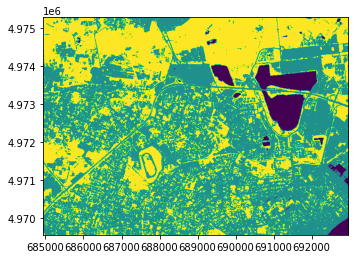

Model RandomForest: (572, 803)


In [41]:
# Afficher les resultats
import rasterio
from rasterio.plot import show

raster = rasterio.open('rf_sentinel_predicted.tif')  
show(raster)
print('Model RandomForest: {sz}'.format(sz=raster.shape))

 

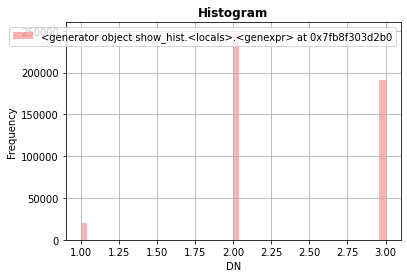

In [33]:
from rasterio.plot import show_hist
show_hist(
    raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")